In [0]:
python3 setup.py install

In [0]:
from google.colab import drive
drive.mount('/content/drive')

# Stock Price Prediction

Context: Instead of using the actual stock price as features, use a combination of the features (returns and stock prices) instead.

# Preparation

## Imports

Importing the libraries

In [0]:
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline
import matplotlib.pyplot as plt

# Importing Time Series libraries
! pip install pmdarima
from pmdarima import auto_arima
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARMA, ARMAResults, ARIMA, ARIMAResults
from statsmodels.tsa.statespace.varmax import VARMAX, VARMAXResults
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tools.eval_measures import mse, rmse, meanabs

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

# Importing Keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.preprocessing.sequence import TimeseriesGenerator

     |████████████████████████████████| 1.1MB 2.8MB/s 


Using TensorFlow backend.


Importing the data

In [0]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
company   = 'AAPL'

filepath  = '/content/drive/My Drive/CS3244/Colab/datasets/' + company + '_data.csv'
raw_df = pd.read_csv(filepath, index_col="date", parse_dates=True)
raw_df = raw_df.resample('B').pad()
raw_df.index.freq = 'B'
raw_df.drop('Name', axis=1, inplace=True)
raw_df.head(5)

,open,high,low,close,volume
date,,,,,
2013-02-08,67.7142,68.4014,66.8928,67.8542,158168416
2013-02-11,68.0714,69.2771,67.6071,68.5614,129029425
2013-02-12,68.5014,68.9114,66.8205,66.8428,151829363
2013-02-13,66.7442,67.6628,66.1742,66.7156,118721995
2013-02-14,66.3599,67.3771,66.2885,66.6556,88809154


## Data Preprocessing

### Modifying and Selecting a dataframe
The function `create_df` creates a new dataframe based on given specifications.






In [0]:
def create_df(raw_df, num_days, 
              include_prices=None, include_returns=None, include_hl=None, include_volume=None,
              classify=None):
  
  # Select all the features that need to be included
  col_list = []
  if include_prices == True:
    col_list += ['close']
  if include_hl == True:
    col_list += ['high','low']
  if include_volume == True:
    col_list += ['volume']
  df = raw_df.copy()[col_list]
  if include_returns == True:
    df['returns'] = raw_df['close'].pct_change()
    df = df.iloc[1:]
    col_list += ['returns']
  
  # Create a sliding window
  for i in range(1,num_days):
    for col in col_list:
      col_name = col + '_' + str(i)
      df[col_name] = df[col].shift(i)
  df = df.iloc[num_days:]

  # Create the label (target)
  # If the target is price prediction
  if include_prices == True:
    df['target_price'] = df['close'].shift(-1)
    df = df.iloc[:-1]
    df['target_class'] = df['target_price'] > df['close']
    if classify == True:
      df = df.drop(columns='target_price')
    else:
      df = df.drop(columns = 'target_class')
  # If the target is prediction of returns
  elif include_returns == True:
    df['target_returns'] = df['returns'].shift(-1)
    df = df.iloc[:-1]
    df['target_class'] = df['target_returns'] > 0
    if classify == True:
      df = df.drop(columns='target_returns')
    else:
      df = df.drop(columns = 'target_class')

  return df

### Creating the dataframe
Inputs for `create_df`:
*   `raw_df`:  The raw dataframe (i.e. the imported data)
*   `num_days`: The number of days in the sliding window. E.g. if it is set to 2, it will include the data for day n and day n-1.
*   `include_prices` (optional): Set to `True` if you wish to include prices
*   `include_returns` (optional): Set to `True` if you wish to include returns
*   `include_hl` (optional): Set to `True` if you wish to include the high and low values
*   `include_volume` (optional): Set to `True` if you wish to include the trading volume
*   `classify` (optional): Set to `True` if you wish to train a classification model. By default, it will be a time series regression model.

#### Demonstration

If you intend to try out the function, modify the function params in the demo tab :)

In [0]:
demo_df = create_df(raw_df,3,
               include_prices=True, 
               include_returns=True, 
               include_hl = False,
               include_volume = False,
               classify = True)
demo_df.head(15)

,close,returns,close_1,returns_1,close_2,returns_2,target_class
date,,,,,,,
2013-02-14,66.6556,-0.000899,66.7156,-0.001903,66.8428,-0.025067,False
2013-02-15,65.7371,-0.013780,66.6556,-0.000899,66.7156,-0.001903,False
2013-02-18,65.7371,0.000000,65.7371,-0.013780,66.6556,-0.000899,False
2013-02-19,65.7128,-0.000370,65.7371,0.000000,65.7371,-0.013780,False
2013-02-20,64.1214,-0.024218,65.7128,-0.000370,65.7371,0.000000,False
2013-02-21,63.7228,-0.006216,64.1214,-0.024218,65.7128,-0.000370,True
2013-02-22,64.4014,0.010649,63.7228,-0.006216,64.1214,-0.024218,False
2013-02-25,63.2571,-0.017768,64.4014,0.010649,63.7228,-0.006216,True
2013-02-26,64.1385,0.013934,63.2571,-0.017768,64.4014,0.010649,False


# Classification Models

## Data for classification models
This will be the dataframe that will be used to train and test the models. We have chosen to keep all features and use a time frame of 3 days. 

In [0]:
num_days = 3
df = create_df(raw_df,num_days,
               include_prices = True, 
               include_returns = True,
               include_hl = True,
               include_volume = True,
               classify = True)
input_dim = num_days * 5
df.head(10)

,close,high,low,volume,returns,close_1,high_1,low_1,volume_1,returns_1,close_2,high_2,low_2,volume_2,returns_2,target_class
date,,,,,,,,,,,,,,,,
2013-02-14,66.6556,67.3771,66.2885,88809154,-0.000899,66.7156,67.6628,66.1742,118721995.0,-0.001903,66.8428,68.9114,66.8205,151829363.0,-0.025067,False
2013-02-15,65.7371,67.1656,65.7028,97924631,-0.013780,66.6556,67.3771,66.2885,88809154.0,-0.000899,66.7156,67.6628,66.1742,118721995.0,-0.001903,False
2013-02-18,65.7371,67.1656,65.7028,97924631,0.000000,65.7371,67.1656,65.7028,97924631.0,-0.013780,66.6556,67.3771,66.2885,88809154.0,-0.000899,False
2013-02-19,65.7128,66.1042,64.8356,108854046,-0.000370,65.7371,67.1656,65.7028,97924631.0,0.000000,65.7371,67.1656,65.7028,97924631.0,-0.013780,False
2013-02-20,64.1214,65.3842,64.1142,118891367,-0.024218,65.7128,66.1042,64.8356,108854046.0,-0.000370,65.7371,67.1656,65.7028,97924631.0,0.000000,False
2013-02-21,63.7228,64.1671,63.2599,111596821,-0.006216,64.1214,65.3842,64.1142,118891367.0,-0.024218,65.7128,66.1042,64.8356,108854046.0,-0.000370,True
2013-02-22,64.4014,64.5142,63.7999,82583823,0.010649,63.7228,64.1671,63.2599,111596821.0,-0.006216,64.1214,65.3842,64.1142,118891367.0,-0.024218,False
2013-02-25,63.2571,65.0171,63.2242,92899597,-0.017768,64.4014,64.5142,63.7999,82583823.0,0.010649,63.7228,64.1671,63.2599,111596821.0,-0.006216,True
2013-02-26,64.1385,64.5056,62.5228,125096657,0.013934,63.2571,65.0171,63.2242,92899597.0,-0.017768,64.4014,64.5142,63.7999,82583823.0,0.010649,False


## KNN Classifier

In [0]:
from sklearn.neighbors import KNeighborsClassifier
df_KNN = df.copy()

y = df_KNN['target_class']
x = df_KNN.drop(['target_class'], axis=1)
x.head()
y.head()

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)

scaler = MinMaxScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

classifier = KNeighborsClassifier(n_neighbors=5)
classifier.fit(x_train, y_train)
y_pred = classifier.predict(x_test)
classifier.score(x_test, y_test)

0.5

## Random Forest Classifier

In [0]:
from sklearn.ensemble import RandomForestClassifier
df_RF = df.copy()

# limit = 100000 # limit samples
y = df_RF['target_class']
x = df_RF.drop(['target_class'], axis=1)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)

classifier = RandomForestClassifier(n_estimators=10, criterion='entropy')
classifier.fit(x_train, y_train)
y_pred = classifier.predict(x_test)
print(classifier.score(x_test, y_test))
cm = confusion_matrix(y_test, y_pred)
cm

0.5307692307692308


array([[77, 47],
       [75, 61]])

## Neural Network Classifier

In [0]:
from keras import optimizers

y = df['target_class']
x = df.drop(['target_class'], axis=1)
model = Sequential()
model.add(Dense(5, input_dim=input_dim, activation='relu'))
model.add(Dense(5, activation='relu'))
model.add(Dense(1, activation='softmax'))

model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer='adam')
model.fit(x, y, epochs=100, batch_size=10)
_, accuracy = model.evaluate(x, y)
print('Accuracy: %.2f' % (accuracy*100))

Epoch 1/100
1299/1299 [==============================] - 0s 357us/step - loss: 7.9773 - acc: 0.4996
Epoch 2/100
1299/1299 [==============================] - 0s 129us/step - loss: 7.9773 - acc: 0.4996
Epoch 3/100
1299/1299 [==============================] - 0s 133us/step - loss: 7.9773 - acc: 0.4996
Epoch 4/100
1299/1299 [==============================] - 0s 129us/step - loss: 7.9773 - acc: 0.4996
Epoch 5/100
1299/1299 [==============================] - 0s 130us/step - loss: 7.9773 - acc: 0.4996
Epoch 6/100
1299/1299 [==============================] - 0s 140us/step - loss: 7.9773 - acc: 0.4996
Epoch 7/100
1299/1299 [==============================] - 0s 136us/step - loss: 7.9773 - acc: 0.4996
Epoch 8/100
1299/1299 [==============================] - 0s 134us/step - loss: 7.9773 - acc: 0.4996
Epoch 9/100
1299/1299 [==============================] - 0s 131us/step - loss: 7.9773 - acc: 0.4996
Epoch 10/100
1299/1299 [==============================] - 0s 141us/step - loss: 7.9773 - acc: 0.4996

## AdaBoost

In [0]:
from sklearn.ensemble import AdaBoostClassifier
df_ada = df.copy()

y = df_ada['target_class']
x = df_ada.drop(['target_class'], axis=1)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)

classifier = AdaBoostClassifier()
classifier.fit(x_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None)

# Time Series Regression Models

## Data for Time Series Models

In [0]:
df = create_df(raw_df,3,
               include_prices=True, 
               include_returns=True,
               include_hl = True,
               include_volume = True,
               classify = False)
df.head(10)

,close,high,low,volume,returns,close_1,high_1,low_1,volume_1,returns_1,close_2,high_2,low_2,volume_2,returns_2,target_price
date,,,,,,,,,,,,,,,,
2013-02-14,66.6556,67.3771,66.2885,88809154,-0.000899,66.7156,67.6628,66.1742,118721995.0,-0.001903,66.8428,68.9114,66.8205,151829363.0,-0.025067,65.7371
2013-02-15,65.7371,67.1656,65.7028,97924631,-0.013780,66.6556,67.3771,66.2885,88809154.0,-0.000899,66.7156,67.6628,66.1742,118721995.0,-0.001903,65.7371
2013-02-18,65.7371,67.1656,65.7028,97924631,0.000000,65.7371,67.1656,65.7028,97924631.0,-0.013780,66.6556,67.3771,66.2885,88809154.0,-0.000899,65.7128
2013-02-19,65.7128,66.1042,64.8356,108854046,-0.000370,65.7371,67.1656,65.7028,97924631.0,0.000000,65.7371,67.1656,65.7028,97924631.0,-0.013780,64.1214
2013-02-20,64.1214,65.3842,64.1142,118891367,-0.024218,65.7128,66.1042,64.8356,108854046.0,-0.000370,65.7371,67.1656,65.7028,97924631.0,0.000000,63.7228
2013-02-21,63.7228,64.1671,63.2599,111596821,-0.006216,64.1214,65.3842,64.1142,118891367.0,-0.024218,65.7128,66.1042,64.8356,108854046.0,-0.000370,64.4014
2013-02-22,64.4014,64.5142,63.7999,82583823,0.010649,63.7228,64.1671,63.2599,111596821.0,-0.006216,64.1214,65.3842,64.1142,118891367.0,-0.024218,63.2571
2013-02-25,63.2571,65.0171,63.2242,92899597,-0.017768,64.4014,64.5142,63.7999,82583823.0,0.010649,63.7228,64.1671,63.2599,111596821.0,-0.006216,64.1385
2013-02-26,64.1385,64.5056,62.5228,125096657,0.013934,63.2571,65.0171,63.2242,92899597.0,-0.017768,64.4014,64.5142,63.7999,82583823.0,0.010649,63.5099


## KNN Regressor

In [0]:
from sklearn.neighbors import KNeighborsRegressor
y = df['target_price']
x = df.drop(['target_price'], axis=1)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, shuffle=False)

scaler = MinMaxScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

regressor = KNeighborsRegressor(n_neighbors=5)
regressor.fit(x_train, y_train)
y_pred = regressor.predict(x_test)
regressor.score(x_test, y_test)

-4.062033920412294

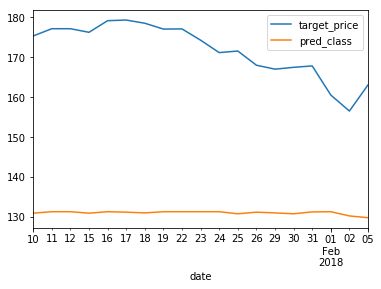

In [0]:
y_test = pd.DataFrame(y_test, columns=['target_price'])
y_pred = pd.DataFrame(y_pred, columns=['pred_class'])
y_test = y_test.reset_index()
y_test = pd.concat([y_test, y_pred], axis=1)
y_test = y_test.iloc[:-1]
y_test['date'] = pd.to_datetime(y_test['date'])
y_test.set_index('date', inplace=True)
y_test.sort_index(inplace=True)
y_test.loc['2018-01-10':].plot()